Create compression version of GPT-2 nad BERT model and save the memory =)

# Transformer-based model compression tutorial

Seminar prepared by Vika Chekalina

In this notebook we will go through the process of GPT-2/BERT compression.

## Brief reminder: 

### Why do we need GPT-2 compression?

- To reduce disk space consumption
- To accelerate model inference
- To reduce energy consumption

### GPT-2 compression pipeline

1) Extract fully-connected (transformers.conv1D()) from pretrained GPT-2

2) Decompose it with linear algebra decomposition method

3) Replace initial fully-connected layer with factorized layer

4) Fine-tune model to recover performance degradation


## Let's go through all of the stages in the pipeline

In [2]:
device = 'cuda'

In [3]:
!pip3 install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
from transformers import GPT2Model, GPT2Config, GPT2LMHeadModel

# Initializing a GPT2 configuration
configuration = GPT2Config()

# Initializing a model from the configuration
model = GPT2LMHeadModel(configuration).from_pretrained("gpt2",
                                                return_dict=True,
                                                is_decoder=True)
outt = model.to(device)

In [5]:
import torch
from torch import nn
import numpy as np

Count parameters number

In [6]:
print ("num parameters in model", model.num_parameters()) #124 mln

num parameters in model 124439808


We will validate a pre-trained language GPT-2 model on a validation part **Wikitext-103** dataset.

To create a validation dataset we should:
    
- download archieved dataset
- extract it
- wrap tran and test parts in TextDataset and further Dataloader class

In [6]:
!pwd
!curl https://s3.amazonaws.com/research.metamind.io/wikitext/wikitext-103-v1.zip -o wikitext-103-v1.zip

/content
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  181M  100  181M    0     0  11.0M      0  0:00:16  0:00:16 --:--:-- 13.4M


In [7]:

!unzip wikitext-103-v1.zip
!ls

Archive:  wikitext-103-v1.zip
   creating: wikitext-103/
  inflating: wikitext-103/wiki.test.tokens  
  inflating: wikitext-103/wiki.valid.tokens  
  inflating: wikitext-103/wiki.train.tokens  
sample_data  wikitext-103  wikitext-103-v1.zip


Create a validation dataset and measure perplexity of regular GPT-2

In [7]:
from torch.utils.data import DataLoader, RandomSampler
from transformers import GPT2Tokenizer
from transformers import TextDataset
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

    
dataset_valid = TextDataset(tokenizer=tokenizer, 
                                file_path="/content/wikitext-103/wiki.valid.tokens", 
                                block_size=512)
    
dataset_test = TextDataset(tokenizer=tokenizer, 
                                file_path="/content/wikitext-103/wiki.test.tokens", block_size=512)
len(dataset_valid), len(dataset_test)

eval_dataloader = DataLoader(dataset_valid, batch_size=10)

/usr/local/lib/python3.9/dist-packages/transformers/data/datasets/language_modeling.py:53: FutureWarning: This dataset will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/language-modeling/run_mlm.py
  warnings.warn(


Validate model and calculate a perplexity:

In [8]:
from tqdm import tqdm
model.eval()
import torch

def evaluate(model):
    losses = []
    eval_loss = 0.0
    perplexity = 0.0
    nb_eval_steps = 0
    for batch in tqdm(eval_dataloader, desc="Evaluating"):
        inputs, labels = (batch, batch)
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            outputs = model(inputs, labels=labels)
            lm_loss = outputs[0]
            eval_loss += lm_loss.mean().item()
            perplexity += torch.exp(torch.tensor(eval_loss))
            losses.append(eval_loss)
        nb_eval_steps += 1

    eval_loss = eval_loss / nb_eval_steps

    perplexity = torch.exp(torch.tensor(eval_loss))
    perplexity = perplexity 
    return perplexity

In [10]:
perplexity = evaluate(model)
perplexity

Evaluating: 100%|██████████| 49/49 [00:24<00:00,  1.98it/s]


tensor(35.1143)

In [11]:
model.transformer.h[1]

GPT2Block(
  (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (attn): GPT2Attention(
    (c_attn): Conv1D()
    (c_proj): Conv1D()
    (attn_dropout): Dropout(p=0.1, inplace=False)
    (resid_dropout): Dropout(p=0.1, inplace=False)
  )
  (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (mlp): GPT2MLP(
    (c_fc): Conv1D()
    (c_proj): Conv1D()
    (act): NewGELUActivation()
    (dropout): Dropout(p=0.1, inplace=False)
  )
)

In [12]:
model.transformer.h[1].mlp.c_proj.weight.shape

torch.Size([3072, 768])

Let's generate text to ensure that model is good.

In [13]:
seq_len = 512

In [14]:
i = 0
for batch_idx, sample in tqdm(enumerate(eval_dataloader)):
    input_ids, label_ids = sample[0][:seq_len - 1], sample[0][1:seq_len]
    input_ids = input_ids.to(device=device)
    label_ids = label_ids.to(device=device)
    outputs = model(input_ids)
    print ("\n")
    print("input_ids[0][-20:]", tokenizer.decode(input_ids[-10:]))
    print ("\n")
    print("label_ids[0][-21:]", tokenizer.decode(input_ids[-11:]))
    print ("\n")
    print("output", tokenizer.decode(outputs.logits.argmax(dim=-1)[-10:]))
    #print("GENERATED", tokenizer.decode(outputs.logits.argmax(dim=-1)[0][-1:]))
    print("\n\n\n")
    i += 1
    if i > 10: break
    print ("\n\n")

3it [00:00, 13.26it/s]



input_ids[0][-20:]  lobster, Homarus americanus. The two species


label_ids[0][-21:]  American lobster, Homarus americanus. The two species


output , Harus gamanus. It American species are









input_ids[0][-20:]  National Forest. The east end of M @-


label_ids[0][-21:] ee National Forest. The east end of M @-


output  Forest. The highwaybound of the @-@









input_ids[0][-20:]  as a liaison between the organizations. Plans were underway


label_ids[0][-21:]  serves as a liaison between the organizations. Plans were underway


output  a liaison between the Meridian and  for made to









7it [00:00, 16.91it/s]



input_ids[0][-20:]  @-@ seat auditorium for live performances,


label_ids[0][-21:]  950 @-@ seat auditorium for live performances,


output ,@ and,ium, the performances, is









input_ids[0][-20:]  @,@ 
 Fred and Al Key,


label_ids[0][-21:]  1964 @,@ 
 Fred and Al Key,


output ,@ 

rick Mary <es the









input_ids[0][-20:] le was the villain. 
 
 =


label_ids[0][-21:] engele was the villain. 
 
 =


output  is a main. 
 "
 = =









input_ids[0][-20:] @ northwesterly track in response to a


label_ids[0][-21:] -@ northwesterly track in response to a


output  orientationwardesterly direction, the to the strong









10it [00:00, 15.29it/s]



input_ids[0][-20:]  is shown standing in a cage opposite to a number


label_ids[0][-21:]  Madonna is shown standing in a cage opposite to a number


output  singing dancing in front white with the the man of









input_ids[0][-20:] -@ lap sprint, Richmond competed in a three


label_ids[0][-21:]  @-@ lap sprint, Richmond competed in a three


output @ race,, Richmond took in the race @









input_ids[0][-20:]  well @-@ being of ranchers. In


label_ids[0][-21:]  economic well @-@ being of ranchers. In


output --@ needs of localhers.  addition









input_ids[0][-20:]  for their first road win in Illinois since 1995.


label_ids[0][-21:]  Illinois for their first road win in Illinois since 1995.


output  the first Big win of four'beating. On






# Which parts of the transformer are best to compress?

Parameters in the parts of thransormer model, MB:

Part \ Model           | GPT-2 small  |  GPT-2 medium | GPT-2 large
-----------------------|--------------|---------------|---------------|
Attention block        | 9.01         |      16.02    |        25.02  |
MLP block              | 18.01        |      32.02    |     50.02     |

# 2. SVD-compression of Fully Connected layer

Linear layer: $Y = X W^T + b$

Singular Value decomposition: $W = U \Sigma V^T$

We use truncated SVD with rank $r$: $U_r = U[:, :r], \Sigma_r = Σ[:r, :r], V_r = V[:, :r]$

Since $\Sigma_r$ is a diagonal matrix of shape $r \times r$, we can fuze it inside $U_r$ and $V_r$ in order to avoid multiplication of X with it during inference time:

$ W_2 = U[:, :r] \sqrt{\Sigma_r}, W_1 = \sqrt{\Sigma_r} V[:, :r]^T$

As a result, we get:

$W ≈ W_2 W_1$ and $Y \approx X W_1^T W_2^T + b$

Which is equivalent to two sequential linear layers - first with weight $W_1$ and zero bias and the second one with weight $W_2$ and bias $b$.

Let $W$ have $n_{in}, n_{out}$ shape.

Then, FLOP number of initial linear layer is $2 \times n_{in} \times (n_{out} + 1)$.

And FLOP number of factorized layer is $2 \times n_{in} \times r + r \times (2 \times n_{out} + 1). $

If $r < \frac{n_{in} \times (n_{out} + 1)}{n_{in} +  n_{out} + 0.5}$, then complexity of factorized layer is lower.

In [15]:
fc_w = model.transformer.h[0].mlp.c_fc.weight.data.cpu().data.numpy()
fc_b = model.transformer.h[0].mlp.c_fc.bias.data.cpu().data.numpy()
fc_w.shape, fc_b.shape

((768, 3072), (3072,))

In [16]:
from transformers.modeling_utils import Conv1D

def factorize_to_svd(fc_w, fc_b, rank):
    U, S, Vt = np.linalg.svd(fc_w, full_matrices=False)
    # truncate SVD and fuse Sigma matrix
    w1 = np.dot(np.diag(np.sqrt(S[0:rank])),Vt[0:rank, :])
    w2 = np.dot(U[:,0:rank,], np.diag(np.sqrt(S[0:rank])))

    # create new layers and insert weights
    out_features, in_features = fc_w.shape
    is_bias = fc_b is not None 

    linear1 = nn.Linear(in_features = in_features, 
                      out_features = rank,
                      bias = False)
    linear1.weight = nn.Parameter(torch.FloatTensor(w1))

    linear2 = nn.Linear(in_features = rank,
                      out_features = out_features,
                      bias=is_bias)
    linear2.weight = nn.Parameter(torch.FloatTensor(w2))
    linear2.bias = nn.Parameter(torch.FloatTensor(fc_b))

    # create factorized layer
    factorized_layer = nn.Sequential(linear1.to(device),linear2.to(device))
    return factorized_layer

We select a fully-connected layer in the 6th, 8th, 9th, 10th and 11th block of GPT-2. 

Note that Conv1D() Transformer class has transposed weight matrix.





In [17]:
for i in [6, 8, 9, 10, 11]:
    # fc part
    fc_w = model.transformer.h[i].mlp.c_fc.weight.data.cpu().data.numpy()
    fc_b = model.transformer.h[i].mlp.c_fc.bias.data.cpu().data.numpy()
    print (fc_w.shape, fc_b.shape)
    factorized_layer = factorize_to_svd(np.transpose(fc_w), fc_b, rank = 50)
    model.transformer.h[i].mlp.c_fc = factorized_layer
    
    fc_w = model.transformer.h[i].mlp.c_proj.weight.data.cpu().data.numpy()
    fc_b = model.transformer.h[i].mlp.c_proj.bias.data.cpu().data.numpy()
    print (fc_w.shape, fc_b.shape)
    factorized_layer = factorize_to_svd(np.transpose(fc_w), fc_b, rank = 50)
    model.transformer.h[i].mlp.c_proj = factorized_layer
    

(768, 3072) (3072,)
(3072, 768) (768,)
(768, 3072) (3072,)
(3072, 768) (768,)
(768, 3072) (3072,)
(3072, 768) (768,)
(768, 3072) (3072,)
(3072, 768) (768,)
(768, 3072) (3072,)
(3072, 768) (768,)


In [18]:
print ("num parameters in model", model.num_parameters())

num parameters in model 102766848


In [19]:
perplexity = evaluate(model.to(device))
perplexity

Evaluating: 100%|██████████| 49/49 [00:23<00:00,  2.09it/s]


tensor(121.1321)

Let's define a function that will iterate over the compression ratios of a fully connected layer, 

apply the selected compression to the selected layers,

and calculate the resulting perplexity**

In [20]:
def evaluate_compression_and_ppx(rank = 50, layer_to_remove = [6, 8, 9, 10, 11]):
    configuration = GPT2Config()
    # Initializing a model from the configuration
    model = GPT2LMHeadModel(configuration).from_pretrained("gpt2",
                                                return_dict=True,
                                                is_decoder=True)
    outt = model.to(device)
    print ("rank", rank)
    print ("layers", layer_to_remove)
    for i in layer_to_remove:
    # fc part
        fc_w = model.transformer.h[i].mlp.c_fc.weight.data.cpu()
        fc_b = model.transformer.h[i].mlp.c_fc.bias.data.cpu().data.numpy()
        factorized_layer = factorize_to_svd(np.transpose(fc_w), fc_b, rank = rank)
        model.transformer.h[i].mlp.c_fc = factorized_layer.to(device)
        
        fc_w = model.transformer.h[i].mlp.c_proj.weight.data.cpu().data.numpy()
        fc_b = model.transformer.h[i].mlp.c_proj.bias.data.cpu().data.numpy()
        print (fc_w.shape, fc_b.shape)
        factorized_layer = factorize_to_svd(np.transpose(fc_w), fc_b, rank = rank)
        model.transformer.h[i].mlp.c_proj = factorized_layer.to(device)
    print ("num parameters in model", model.num_parameters()) 
    perplexity = evaluate(model)
    print ("perplexity", perplexity)
    return perplexity

In [21]:
ranks = []
ppxs = []
for rank in [50, 100, 200, 300, 400, 500]:
    ppx = evaluate_compression_and_ppx(rank = rank, layer_to_remove = [6, 8, 9, 10, 11])
    ranks.append(rank)
    ppxs.append(ppx.data)

rank 50
layers [6, 8, 9, 10, 11]
(3072, 768) (768,)
(3072, 768) (768,)
(3072, 768) (768,)
(3072, 768) (768,)
(3072, 768) (768,)
num parameters in model 102766848


Evaluating: 100%|██████████| 49/49 [00:21<00:00,  2.23it/s]


perplexity tensor(121.1321)
rank 100
layers [6, 8, 9, 10, 11]
(3072, 768) (768,)
(3072, 768) (768,)
(3072, 768) (768,)
(3072, 768) (768,)
(3072, 768) (768,)
num parameters in model 104686848


Evaluating: 100%|██████████| 49/49 [00:22<00:00,  2.15it/s]


perplexity tensor(103.6401)
rank 200
layers [6, 8, 9, 10, 11]
(3072, 768) (768,)
(3072, 768) (768,)
(3072, 768) (768,)
(3072, 768) (768,)
(3072, 768) (768,)
num parameters in model 108526848


Evaluating: 100%|██████████| 49/49 [00:22<00:00,  2.16it/s]


perplexity tensor(74.4626)
rank 300
layers [6, 8, 9, 10, 11]
(3072, 768) (768,)
(3072, 768) (768,)
(3072, 768) (768,)
(3072, 768) (768,)
(3072, 768) (768,)
num parameters in model 112366848


Evaluating: 100%|██████████| 49/49 [00:24<00:00,  2.03it/s]


perplexity tensor(59.4694)
rank 400
layers [6, 8, 9, 10, 11]
(3072, 768) (768,)
(3072, 768) (768,)
(3072, 768) (768,)
(3072, 768) (768,)
(3072, 768) (768,)
num parameters in model 116206848


Evaluating:  39%|███▉      | 19/49 [00:09<00:14,  2.04it/s]


KeyboardInterrupt: ignored

In [ ]:
%pylab_inline

UsageError: Line magic function `%pylab_inline` not found.


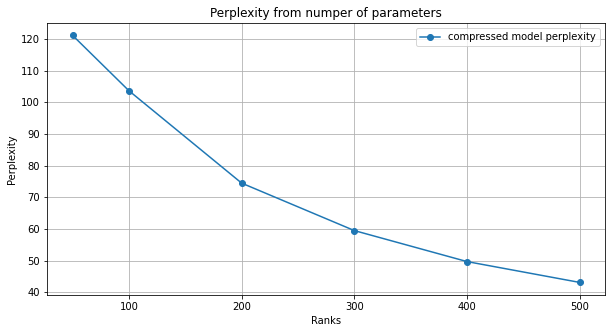

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(ranks, ppxs, marker = 'o', label="compressed model perplexity")
plt.grid()
plt.title("Perplexity from numper of parameters")
plt.xlabel("Ranks")
plt.ylabel("Perplexity")
plt.legend()
plt.show()

# Pruning 

To be sure that problems cannot be solved by simply removing layers, 

we replace the weight matrix with random initializations and calculate the final perplexity.

In [22]:
model = GPT2LMHeadModel(configuration).from_pretrained("gpt2",
                                                return_dict=True,
                                                is_decoder=True)
outt = model.to(device)

In [23]:
from transformers.modeling_utils import Conv1D
for i in [6, 8, 9, 10, 11]:
    # fc part
    fc_w = model.transformer.h[i].mlp.c_fc.weight.data.cpu().data.numpy()
    fp_w = model.transformer.h[i].mlp.c_proj.weight.data.cpu().data.numpy()
    model.transformer.h[i].mlp.c_fc = Conv1D(nx = fc_w.shape[0], nf = 2600)
    model.transformer.h[i].mlp.c_proj = Conv1D(nx = 2600, nf = fc_w.shape[0])

In [24]:
print ("num parameters in model", model.num_parameters() - 10*np.prod(model.transformer.h[i].mlp.c_fc.weight.shape))

num parameters in model 100844488


In [25]:
perplexity = evaluate(model.to(device))
perplexity

Evaluating: 100%|██████████| 49/49 [00:26<00:00,  1.87it/s]


tensor(118.8574)

This is much more than in the pre-trained and in compressed model!

## TTM decomposition

![Text](https://drive.google.com/uc?export=view&id=1b0ugHDiPUJvTuoXeJxO_4ehaSYpdwsvY)



In [26]:
!pip3 install tntorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.4/61.4 KB 7.6 MB/s eta 0:00:00


In [9]:
import tntorch as tn

def tt_multiply(tt_matrix: tn.TTMatrix, tensor: torch.Tensor):
    """
    Multiply TTMatrix by any tensor of more than 1-way.
    For vectors, reshape them to matrix of shape 1 x I
    returns: torch.Tensor of shape b x num_cols(tt_matrix)
    """

    assert len(tensor.shape) > 1
    
    #print("b.shape: ", tensor.shape)
    #print("matrix shapes:")
    #for elem in tt_matrix.cores:
      #print(elem.shape)
    #print("\n")

    rows = torch.prod(tt_matrix.input_dims)
    bs = tensor.shape[0]
    seq_len = tensor.shape[1]
    b = tensor.reshape(-1, rows).shape[0]
    tensor = tensor.reshape(b, -1).T
    result = tensor.reshape(tt_matrix.input_dims[0], -1)
    #print ("b new shape ", result.shape)
    #print ("core shape ", tt_matrix.cores[0].shape)
    result = torch.einsum('id,lior->ldor', result, tt_matrix.cores[0])
    #print ("result shape ", result.shape)
    #print("\n")

    for d in range(1, tt_matrix.d):
        result = result.reshape(tt_matrix.input_dims[d], -1, tt_matrix.cores[d].shape[0])
        #print ("result input shape ", result.shape)
        #print ("core shape ", tt_matrix.cores[d].shape)
        result = torch.einsum('idr,riob->dob', result, tt_matrix.cores[d])
        #print ("result output shape ", result.shape)
        #print("\n")
    #print ("output", result.reshape(b, -1).shape)
    return result.reshape(bs, seq_len, -1)

In [13]:
class TTLinear(nn.Module):
    def __init__(self, in_features, out_features, ranks, input_dims, 
                 output_dims, bias = True, device=None, dtype=None):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.ranks = ranks
        self.input_dims = input_dims
        self.output_dims = output_dims

        # Initialize Тweights from uniform[-1 / sqrt(in_features), 1 / sqrt(in_features)]
        factory_kwargs = {"device": device, "dtype": dtype}
        init = torch.rand(in_features, out_features, **factory_kwargs)
        init = (2 * init - 1) / np.sqrt(in_features)
        self.weight = tn.TTMatrix(init, ranks, input_dims, output_dims)
        
        # torch doesn't recognize attributes of self.weight as parameters,
        # so we have to specify them
        self.cores = nn.ParameterList([nn.Parameter(core) for core in self.weight.cores])
        self.weight.cores = self.cores

        if bias:
            init = torch.rand(out_features, **factory_kwargs)
            init = (2 * init - 1) / np.sqrt(out_features)
            self.bias = nn.Parameter(init)
        else:
            self.register_parameter('bias', None)


    def forward(self, x: torch.Tensor):
        res = tt_multiply(self.weight, x)
        if self.bias is not None:
            res += self.bias
        return res

    def set_weight(self, new_weights: torch.Tensor):
        # in regular linear layer weights are transposed, so we transpose back
        new_weights = new_weights.clone().detach()

        shape = torch.Size((self.in_features, self.out_features))
        assert new_weights.shape == shape, f"Expected shape {shape}, got {new_weights.shape}"

        self.weight = tn.TTMatrix(new_weights, self.ranks, self.input_dims, self.output_dims)
        self.cores = nn.ParameterList([nn.Parameter(core) for core in self.weight.cores])
        self.weight.cores = self.cores

    def set_from_linear(self, linear: nn.Linear, transpose=False):
        if transpose:
            self.set_weight(linear.weight.data.T)
        else:
            self.set_weight(linear.weight.data)
        self.bias = torch.nn.Parameter(linear.bias.data.clone()) if linear.bias is not None else None
        print (linear.bias.shape)

In [11]:
layer = TTLinear(3072, 768, [10, 10, 10], [8, 8, 6,8], [4, 6, 8,4], bias=True)
input = torch.rand(2, 5, 3072)/10

In [12]:
a = layer(input)

In [ ]:
for core in layer.cores:
  print (core.shape)

torch.Size([1, 8, 4, 10])
torch.Size([10, 8, 6, 10])
torch.Size([10, 6, 8, 10])
torch.Size([10, 8, 4, 1])


In [40]:
model = GPT2LMHeadModel(configuration).from_pretrained("gpt2",
                                                return_dict=True,
                                                is_decoder=True)
model.to(device)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [14]:
for i in [6, 8, 9, 10, 11]:
    # fc part
    fc_w = model.transformer.h[i].mlp.c_fc
    fp_w = model.transformer.h[i].mlp.c_proj
    model.transformer.h[i].mlp.c_proj = TTLinear(3072, 768, [50, 50, 50], [8, 8, 6,8], [4, 6, 8,4], bias=True)
    model.transformer.h[i].mlp.c_proj.set_from_linear(fp_w)
    model.transformer.h[i].mlp.c_fc = TTLinear(768, 3072, [50, 50, 50], [4, 6, 8,4], [8, 8, 6,8], bias=True)
    model.transformer.h[i].mlp.c_fc.set_from_linear(fc_w)

torch.Size([768])
torch.Size([3072])
torch.Size([768])
torch.Size([3072])
torch.Size([768])
torch.Size([3072])
torch.Size([768])
torch.Size([3072])
torch.Size([768])
torch.Size([3072])


In [36]:
print ("num parameters in model", model.num_parameters())

num parameters in model 102403328


In [15]:
perplexity = evaluate(model.to(device))
perplexity

Evaluating: 100%|██████████| 49/49 [01:50<00:00,  2.26s/it]


tensor(134.4465)

## Fine-Tune (Bonus)

In [ ]:
dataset_train = TextDataset(tokenizer=tokenizer, 
                                file_path="/content/wikitext-103/wiki.train.tokens", block_size=512)

train_dataloader = DataLoader(dataset_train, batch_size=10)

KeyboardInterrupt: ignored

In [ ]:
from transformers import get_cosine_schedule_with_warmup

In [ ]:
epochs = 10
gradient_accumulation_steps = 12
num_train_batches = len(train_dataloader)
cross_entropy = torch.nn.CrossEntropyLoss(ignore_index=tokenizer.eos_token_id)
training_steps = num_train_batches // gradient_accumulation_steps * epochs
optimizer = torch.optim.Adam(model.parameters(), lr=6.25e-5)
scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=800, num_training_steps=training_steps)


for epoch in range(1, 10):
    
    train_loss = 0
    epoch_iterator = tqdm(train_dataloader, desc="Iteration", disable=True)
    for train_batch_idx, item in enumerate(epoch_iterator):
        optimizer.zero_grad() # in case there are unused accumulated gradients
        
        model.train()
        src, tgt = (item, item)
        src = src.to(device=device)
        tgt = tgt.to(device=device)

    
        output = model(input_ids=src, labels=tgt)
        loss = output.loss
        train_loss += loss.item() # before gradient accumulation step
        if gradient_accumulation_steps > 1:
            loss = loss / gradient_accumulation_steps
        loss.backward() # accumulate gradients
            
        if train_batch_idx % gradient_accumulation_steps == 0:
            optimizer.step()
            scheduler.step()  # Update learning rate schedule
            optimizer.zero_grad()
            
        if train_batch_idx % 1000 == 0:
            print ("loss", loss)
            perplexity = evaluate(model)
            print ("perplexity", perplexity)
                    

## stsb example

The Semantic Textual Similarity Benchmark (Cer et al., 2017) is a collection of sentence pairs drawn from news headlines, video and image captions, and natural language inference data. Each pair is human-annotated with a similarity score from 0 to 5.

In [16]:
!pip install datasets evaluate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.7/468.7 KB 34.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 KB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 KB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 KB 20.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 68.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 28.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 KB 22.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 KB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 KB 33.0 MB/s eta 0:00:00


In [17]:
from datasets import load_dataset
import pandas as pd

dataset_stsb = load_dataset('glue', 'stsb')
dataset_stsb.num_rows

Generating train split:   0%|          | 0/5749 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1500 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1379 [00:00<?, ? examples/s]

Dataset glue downloaded and prepared to /root/.cache/huggingface/datasets/glue/stsb/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

{'train': 5749, 'validation': 1500, 'test': 1379}

In [18]:
pd.DataFrame(dataset_stsb['train']).head(13)

,sentence1,sentence2,label,idx
0,A plane is taking off.,An air plane is taking off.,5.000,0
1,A man is playing a large flute.,A man is playing a flute.,3.800,1
2,A man is spreading shreded cheese on a pizza.,A man is spreading shredded cheese on an uncoo...,3.800,2
3,Three men are playing chess.,Two men are playing chess.,2.600,3
4,A man is playing the cello.,A man seated is playing the cello.,4.250,4
5,Some men are fighting.,Two men are fighting.,4.250,5
6,A man is smoking.,A man is skating.,0.500,6
7,The man is playing the piano.,The man is playing the guitar.,1.600,7
8,A man is playing on a guitar and singing.,A woman is playing an acoustic guitar and sing...,2.200,8
9,A person is throwing a cat on to the ceiling.,A person throws a cat on the ceiling.,5.000,9


In [19]:
task_num_labels = 1

from transformers import AutoConfig, BertConfig, AutoModelForSequenceClassification, AutoTokenizer

path_name = r"bert-base-uncased"

config = AutoConfig.from_pretrained(
    path_name,
    num_labels=task_num_labels,
)

model = AutoModelForSequenceClassification.from_pretrained(
    path_name,
    config=config,
)

tokenizer = AutoTokenizer.from_pretrained(path_name)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [20]:
def convert_to_stsb_features(example_batch):
    inputs = list(zip(example_batch['sentence1'], example_batch['sentence2']))
    features = tokenizer.batch_encode_plus(
        inputs, max_length=128, truncation=True, padding="max_length")
    features["labels"] = example_batch["label"]
    return features

In [21]:
tokenized_dataset = dataset_stsb.map(
            convert_to_stsb_features,
            batched=True,
            load_from_cache_file=False,
            )

Map:   0%|          | 0/5749 [00:00<?, ? examples/s]

Map:   0%|          | 0/1500 [00:00<?, ? examples/s]

Map:   0%|          | 0/1379 [00:00<?, ? examples/s]

In [22]:
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 5749
    })
    validation: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 1500
    })
    test: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 1379
    })
})

In [23]:
from transformers.modeling_utils import Conv1D

def factorize_to_svd(fc_w, fc_b, rank):
    U, S, Vt = np.linalg.svd(fc_w, full_matrices=False)
    # truncate SVD and fuse Sigma matrix
    w1 = np.dot(np.diag(np.sqrt(S[0:rank])),Vt[0:rank, :])
    w2 = np.dot(U[:,0:rank,], np.diag(np.sqrt(S[0:rank])))

    # create new layers and insert weights
    out_features, in_features = fc_w.shape
    is_bias = fc_b is not None 

    linear1 = nn.Linear(in_features = in_features, 
                      out_features = rank,
                      bias = False)
    linear1.weight = nn.Parameter(torch.FloatTensor(w1))

    linear2 = nn.Linear(in_features = rank,
                      out_features = out_features,
                      bias=is_bias)
    linear2.weight = nn.Parameter(torch.FloatTensor(w2))
    linear2.bias = nn.Parameter(torch.FloatTensor(fc_b))

    # create factorized layer
    factorized_layer = nn.Sequential(linear1.to(device),linear2.to(device))
    return factorized_layer

Due to OOM errors with TTM, we need a optimized einsum version

In [24]:
!pip install gdown
!gdown https://drive.google.com/uc?id=1jfJWEtEo9CIbH-I56EFZ8_EyK_PcZtNn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Downloading...
From: https://drive.google.com/uc?id=1jfJWEtEo9CIbH-I56EFZ8_EyK_PcZtNn
To: /content/ttm_opt.py
100% 5.47k/5.47k [00:00<00:00, 9.92MB/s]


In [25]:
from transformers import Trainer
import evaluate as ev
import numpy as np

from transformers import TrainingArguments, Trainer, EvalPrediction

In [26]:
metric = ev.load("glue", 'stsb')

In [27]:
def compute_metrics(p: EvalPrediction):
        preds_ = p.predictions[0] if isinstance(p.predictions, tuple) else p.predictions
        preds_ = np.squeeze(preds_)

        result = metric.compute(predictions=preds_, 
                                references=p.label_ids)
        if len(result) > 1:
            result["combined_score"] = np.mean(list(result.values())).item()
        return result

In [28]:
training_args = TrainingArguments(
    learning_rate=5e-5,
    num_train_epochs=1,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=128,
    save_steps=100,
    eval_steps=100,
    output_dir="./bert_stsb_128",
    overwrite_output_dir=True,
    # The next line is important to ensure the dataset labels are properly passed to the model
    remove_unused_columns=True,
    seed=297104,
    )

In [29]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    compute_metrics=compute_metrics,
)

In [30]:
trainer.train()

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss


TrainOutput(global_step=360, training_loss=0.892444356282552, metrics={'train_runtime': 149.0492, 'train_samples_per_second': 38.571, 'train_steps_per_second': 2.415, 'total_flos': 378152969002752.0, 'train_loss': 0.892444356282552, 'epoch': 1.0})

In [32]:
trainer.evaluate()

{'eval_loss': 0.49646762013435364,
 'eval_pearson': 0.8830570315149948,
 'eval_spearmanr': 0.8792588764670051,
 'eval_combined_score': 0.8811579539909999,
 'eval_runtime': 11.9633,
 'eval_samples_per_second': 125.383,
 'eval_steps_per_second': 1.003,
 'epoch': 1.0}

In [31]:
trainer.save_model()  # Saves the tokenizer too for easy upload
#trainer.log_metrics("train", metrics)
metrics = trainer.evaluate()
trainer.save_metrics("eval", metrics)
trainer.save_state()
sst_new_path = r"./bert_stsb_128"

In [33]:
#our model's params
orig_param = trainer.model.num_parameters() / 1000 / 1000
orig_param

109.48300900000001

In [34]:
device='cuda'
def svd_compress_bert_ffn(model_to, svd_rank = 51):
    for i in range(model_to.config.num_hidden_layers):
        # fc part
        fc_w = model_to.bert.encoder.layer[i].intermediate.dense.weight.data.cpu().data.numpy()
        fc_b = model_to.bert.encoder.layer[i].intermediate.dense.bias.data.cpu().data.numpy()
        factorized_layer = factorize_to_svd(fc_w, fc_b, rank = svd_rank)
        model_to.bert.encoder.layer[i].intermediate.dense = factorized_layer
        
        fc_w = model_to.bert.encoder.layer[i].output.dense.weight.data.cpu().data.numpy()
        fc_b = model_to.bert.encoder.layer[i].output.dense.bias.data.cpu().data.numpy()
        factorized_layer = factorize_to_svd(fc_w, fc_b, rank = svd_rank)
        model_to.bert.encoder.layer[i].output.dense = factorized_layer

In [35]:
from typing import List, Callable
import torch
import torch.nn as nn
import tntorch as tn
from math import sqrt

from ttm_opt import einsum_forward

class TTLinearOpt(nn.Module):
    def __init__(self, in_features: int, out_features: int, ranks: List[int], input_dims: List[int],
                 output_dims: List[int], bias: bool = True, device=None, dtype=None,
                 forward_fn: Callable = einsum_forward):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.ranks = list(ranks)
        self.input_dims = input_dims
        self.output_dims = output_dims
        self.forward_fn = forward_fn

        # Initialize weights from uniform[-1 / sqrt(in_features), 1 / sqrt(in_features)]
        factory_kwargs = {"device": device, "dtype": dtype}
        init = torch.rand(in_features, out_features, **factory_kwargs)
        init = (2 * init - 1) / sqrt(in_features)
        
        self.weight = tn.TTMatrix(init, list(ranks), input_dims, output_dims)

        # torch doesn't recognize attributes of self.weight as parameters,
        # so we have to use ParameterList
        self.cores = nn.ParameterList([nn.Parameter(core) for core in self.weight.cores])
        self.weight.cores = self.cores

        if bias:
            init = torch.rand(out_features, **factory_kwargs)
            init = (2 * init - 1) / sqrt(out_features)
            self.bias = nn.Parameter(init)
        else:
            self.register_parameter('bias', None)


    def forward(self, x: torch.Tensor):
        res = self.forward_fn(self.cores, x)

        new_shape = x.shape[:-1] + (self.out_features,)
        res = res.reshape(*new_shape)

        if self.bias is not None:
            res += self.bias

        return res

    def set_weight(self, new_weights: torch.Tensor):
        # in regular linear layer weights are transposed, so we transpose back
        new_weights = new_weights.clone().detach().T

        shape = torch.Size((self.in_features, self.out_features))
        assert new_weights.shape == shape, f"Expected shape {shape}, got {new_weights.shape}"

        self.weight = tn.TTMatrix(new_weights, self.ranks, self.input_dims, self.output_dims)
        self.cores = nn.ParameterList([nn.Parameter(core) for core in self.weight.cores])
        self.weight.cores = self.cores

    def set_from_linear(self, linear: nn.Linear):
        self.set_weight(linear.weight.data)
        self.bias = nn.Parameter(linear.bias.data.clone()) if linear.bias is not None else None

In [36]:
def ttm_compress_bert_ffn(model, rank):
    if hasattr(model, "bert") and hasattr(model.bert, "encoder"):
        encoder = model.bert.encoder
    elif hasattr(model, "encoder"):
        encoder = model.encoder
    else:
        raise ValueError("Expected model to have attribute 'encoder' or 'bert.encoder'.")

    for i, layer in enumerate(encoder.layer):
        token_dim, hidden_dim = layer.intermediate.dense.weight.T.shape

        tt_weight = TTLinearOpt(768, 3072, [rank]*2,  [8,12,8], [12,16,16], bias=True)
        tt_weight.set_from_linear(layer.intermediate.dense)

        layer.intermediate.dense = tt_weight

        # second linear layerhas reversed dimensions,
        # so we swap input_dims and output_dims
        tt_weight = TTLinearOpt(3072, 768, [rank]*2, [12,16,16], [8,12,8], bias=True)
        tt_weight.set_from_linear(layer.output.dense)

        layer.output.dense = tt_weight

    return model

In [37]:
from tqdm import tqdm

In [38]:
dd = []
device='cuda'
for ii in tqdm([6,10,20]):
    trainer.model = AutoModelForSequenceClassification.from_pretrained(
                                                    sst_new_path,
                                                    config=config,
                                                    )
    svd_compress_bert_ffn(trainer.model, ii)
    trainer.model.to('cuda')
    new_param = trainer.model.num_parameters() / 1000 / 1000
    new_param /= orig_param
    ar = trainer.evaluate(tokenized_dataset["validation"])
    dd.append([new_param, ar['eval_pearson']])


  0%|          | 0/3 [00:00<?, ?it/s]


100%|██████████| 3/3 [02:06<00:00, 42.07s/it]


In [ ]:
dd_ttm = []
for ii in tqdm([6,10,20]): #,42,48,54,60,66,72,78,84]):
    trainer.model = AutoModelForSequenceClassification.from_pretrained(
                                                    sst_new_path,
                                                    config=config,
                                                    )
    ttm_compress_bert_ffn(trainer.model,ii)
    trainer.model.to('cuda')
    new_param = trainer.model.num_parameters() / 1000 / 1000
    new_param /= orig_param
    ar = trainer.evaluate(tokenized_dataset["validation"])
    dd_ttm.append([new_param, ar['eval_pearson']])

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [01:52<00:00, 37.61s/it]


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

<Axes: xlabel='% of original params', ylabel='1'>

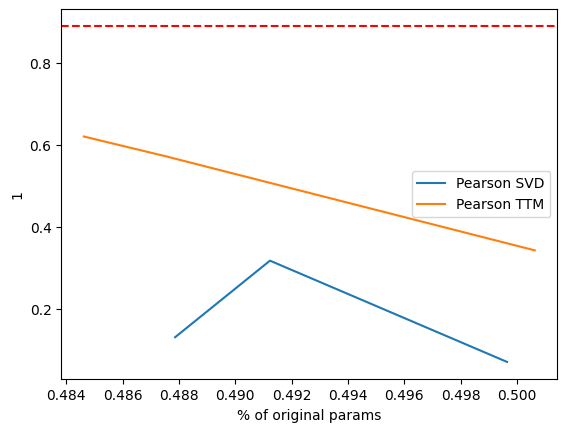

In [ ]:
ax = sns.lineplot(x=0, y=1, data = pd.DataFrame(dd), label='Pearson SVD')
plt.axhline(y=0.89, ls='--', c='red') #non-compressed accuracy
ax.set(xlabel ='% of original params')
sns.lineplot(x=0, y=1, data = pd.DataFrame(dd_ttm), label='Pearson TTM')